In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os#Walking through directores

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots

from sklearn import decomposition #pca
from sklearn.preprocessing import StandardScaler # Standardization ((X - X_mean)/X_std)

pd.set_option('display.max_columns', None)#Setting Max Columns Display to Max inorder to get glance of all features in dataframe

from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train (1).csv


In [ ]:
import io

missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #Sometimes Missing Values are't in form of NaN
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']),sep=';') 
print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

There are Total 70000 datapoints in the dataset with 13 Features listed as ['id' 'age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'cardio']:


In [ ]:
features_with_null = [features for feature in df.columns if df[feature].isnull().sum()>0]
if features_with_null:
    print('Features with Null Values {}'.format(features_with_null))
else:
    print('Dataset contains no Null Values')

Dataset contains no Null Values


In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 24


In [ ]:
df.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(df.shape[0], df.shape[1]))

Total 69976 datapoints remaining with 12 features


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Height Distribution", "Weight Distribution"))

trace0 = go.Histogram(x=df['height'], name = 'Height')
trace1 = go.Histogram(x=df['weight'], name = 'Weight')


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig.update_xaxes(title_text="Height", row=1, col=1)
fig.update_yaxes(title_text="Total Count", row=1, col=1)

fig.update_xaxes(title_text="Weight", row=1, col=2)
fig.update_yaxes(title_text="Total Count", row=1, col=2)

fig.update_layout(title_text="Histograph", height=700)


fig.show()

In [ ]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [ ]:
outline_free_df = df.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [ ]:
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


In [ ]:
print('Handling outliners cost us {} datapoints'.format(len(df)-len(outline_free_df)))

Handling outliners cost us 1630 datapoints


In [ ]:
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [ ]:
print('There are total {} observations where ap_hi < ap_lo'.format(len(outline_free_df[outline_free_df['ap_hi'] < outline_free_df['ap_lo']])))

There are total 1182 observations where ap_hi < ap_lo


In [ ]:
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


In [ ]:
print('As per our assumptions we have total {} outliers'.format(len(cleaned_data[(cleaned_data["ap_hi"]>250) | (cleaned_data["ap_lo"]>200)])))

As per our assumptions we have total 38 outliers


In [ ]:
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]

In [ ]:
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 67118 datapoints remaining with 12 features


In [ ]:
cleaned_data.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2  5.123964  4.127134    110     80            1     1      0   
1  20228       1  5.049856  4.442651    140     90            3     1      0   
2  18857       1  5.105945  4.158883    130     70            3     1      0   
3  17623       2  5.129899  4.406719    150    100            1     1      0   
4  17474       1  5.049856  4.025352    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [ ]:
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=cleaned_data['age'], name = 'Age'))
fig.show()

In [ ]:
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [ ]:
duplicated = cleaned_data[cleaned_data.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
22272   57       2  5.192957  4.605170    120     80            1     1   
58984   57       2  5.192957  4.605170    120     80            1     1   
9953    40       2  5.192957  4.382027    120     80            1     1   
20350   56       2  5.192957  4.382027    150     90            1     1   
28371   56       2  5.192957  4.382027    150     90            1     1   

       smoke  alco  active  cardio  
22272      0     0       1       0  
58984      0     0       1       0  
9953       0     0       1       0  
20350      0     0       1       1  
28371      0     0       1       1

In [ ]:
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], df.shape[1]))

Total 63938 datapoints remaining with 12 features


In [ ]:
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Age groups grouped by Target Value", 
                  yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Age',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

In [ ]:
target_value = cleaned_data['cardio']
cleaned_data_for_pca = cleaned_data.drop(['cardio'], axis=1)

In [ ]:
scaled_data = StandardScaler().fit_transform(cleaned_data_for_pca)

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(scaled_data)

pca_data = np.vstack((pca_data.T, target_value)).T
pca_df = pd.DataFrame(data = pca_data, columns = ('first', 'second', 'label'))

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = pca_df['first'], 
    y = pca_df['second'],
    mode='markers',
    marker_color=pca_df['label']
))

fig.show()

In [ ]:
def BMI(data):
    return np.exp(data['weight']) / (np.exp(data['height'])/100)**2 
 
cleaned_data['bmi'] = cleaned_data.apply(BMI, axis=1)

In [ ]:
def pulse(data):
    return np.subtract(data['ap_hi'], data['ap_lo'])
 
cleaned_data['pulse'] = cleaned_data.apply(pulse, axis=1)

In [ ]:
cleaned_data

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
0       50       2  5.123964  4.127134    110     80            1     1   
1       55       1  5.049856  4.442651    140     90            3     1   
2       51       1  5.105945  4.158883    130     70            3     1   
3       48       2  5.129899  4.406719    150    100            1     1   
4       47       1  5.049856  4.025352    100     60            1     1   
...    ...     ...       ...       ...    ...    ...          ...   ...   
67150   53       1  5.147494  4.248495    130     90            1     1   
67151   57       1  5.105945  4.382027    150     80            1     1   
67153   52       2  5.209486  4.653960    180     90            3     1   
67154   61       1  5.093750  4.276666    135     80            1     2   
67155   56       1  5.135798  4.276666    120     80            2     1   

       smoke  alco  active  cardio        bmi  pulse  
0          0     0       1       0  21.967120   30.0  
1          0     0       1       1  34.927679   50.0  
2          0     0       0       1  23.507805   60.0  
3          0     0       1       1  28.710479   50.0  
4          0     0       0       0  23.011177   40.0  
...      ...   ...     ...     ...        ...    ...  
67150      0     0       1       1  23.661439   40.0  
67151      0     0       1       1  29.384757   70.0  
67153      0     1       0       1  31.353579   90.0  
67154      0     0       0       1  27.099251   55.0  
67155      0     0       1       0  24.913495   40.0  

[63938 rows x 14 columns]

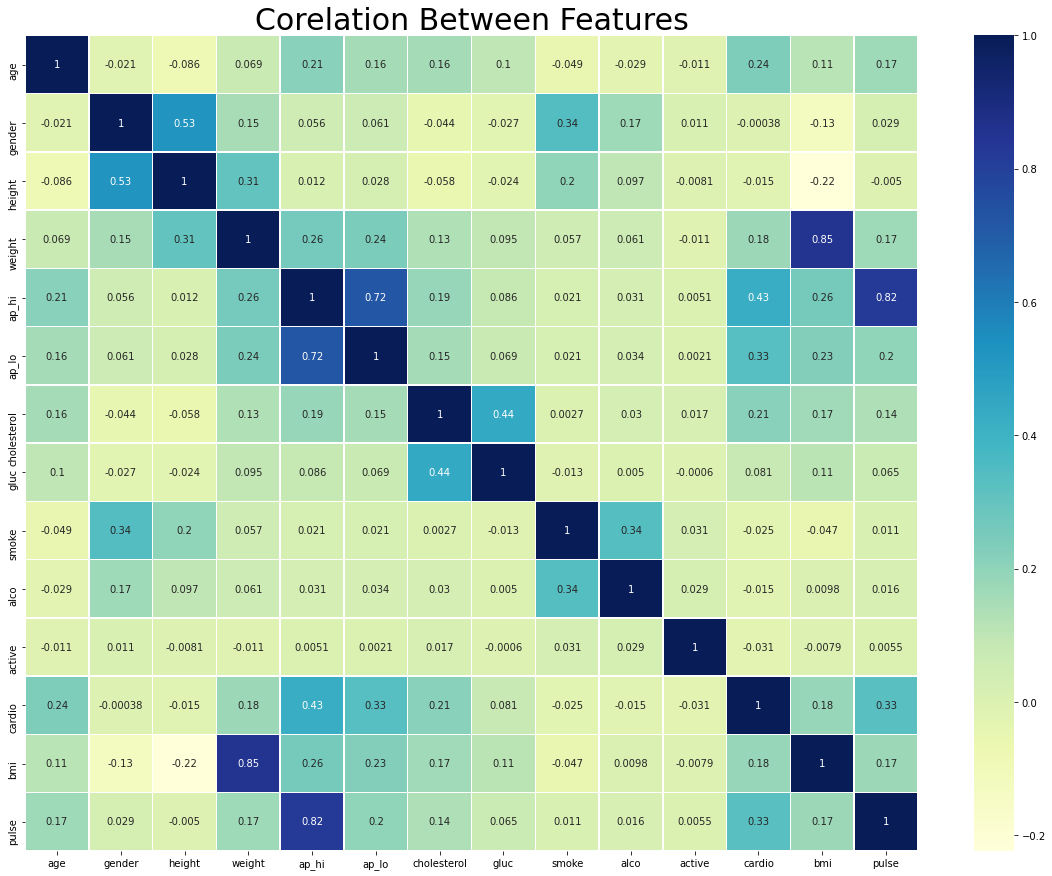

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(cleaned_data.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

In [ ]:
cleaned_data = cleaned_data[:2000]

X = cleaned_data.drop(['cardio', 'bmi', 'weight', 'gluc', 'gender', 'smoke', 'alco', 'active'], axis =1)
y = cleaned_data['cardio']

In [ ]:

X = X.to_numpy()
y = y.to_numpy()

In [ ]:
!pip install alipy

     |████████████████████████████████| 122kB 4.9MB/s 
  Created wheel for alipy: filename=alipy-1.2.4-cp37-none-any.whl size=120687 sha256=90c7c8ecab0910d64264a1a827bf72c036fef80b39bda2880224f25cdc8d6dab
  Stored in directory: /root/.cache/pip/wheels/5a/1b/f5/be0fc4f9e53771e82ea97f681c1b69c2bab03e4997b52644b8
Successfully built alipy


[[ 50.           5.12396398 110.          80.           1.
   30.        ]
 [ 55.           5.04985601 140.          90.           3.
   50.        ]
 [ 51.           5.10594547 130.          70.           3.
   60.        ]
 ...
 [ 60.           5.11799381 134.          84.           2.
   50.        ]
 [ 50.           5.06259503 120.          80.           1.
   40.        ]
 [ 57.           5.09986643 120.          80.           3.
   40.        ]]

| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   140 (10.00% of all)  |         50        |  0   | 0.732 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   140 (10.00% of all)  |         50        |  0   | 0.743 ± 0.00 |
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   140 (10.00% of all)  |         50        |  0   | 0.736 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   

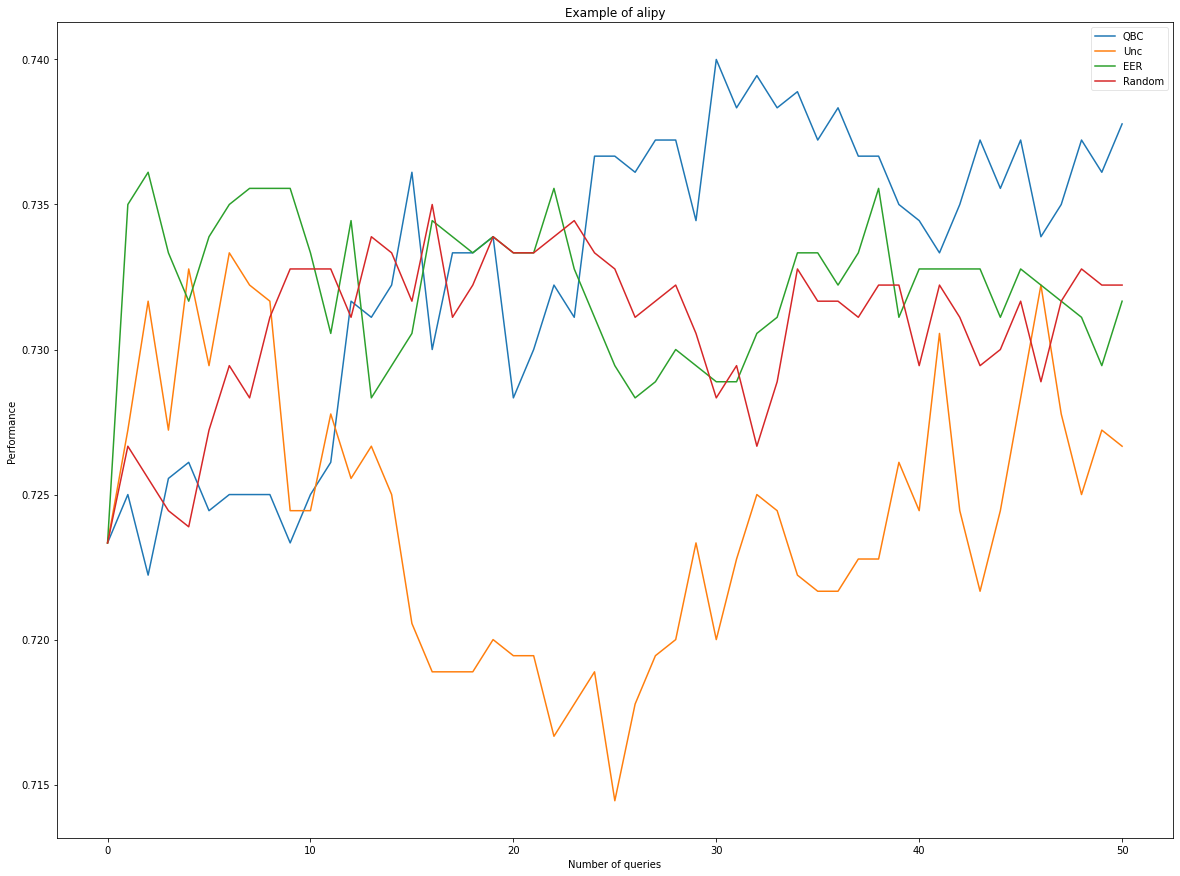

In [ ]:
from alipy import ToolBox
import copy

alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

# Use the default Logistic Regression classifier
model = alibox.get_default_model()

# The cost budget is 50 times querying
stopping_criterion = alibox.get_stopping_criterion('num_of_queries', 50)

print(X)


def main_loop(alibox, strategy, round):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
    # Get intermediate results saver for one fold experiment
    saver = alibox.get_stateio(round, saving_path=f"./{strategy.__class__.__name__}_{round}.pkl")

    # Set initial performance point
    model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
    pred = model.predict(X[test_idx, :])
    accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                              y_pred=pred,
                                              performance_metric='accuracy_score')
    saver.set_initial_point(accuracy)

    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
    while not stopping_criterion.is_stop():
        # Select a subset of Uind according to the query strategy
        # Passing model=None to use the default model for evaluating the committees' disagreement
        select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, batch_size=1, model=model)
        label_ind.update(select_ind)
        unlab_ind.difference_update(select_ind)

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')

        # Save intermediate results to file
        st = alibox.State(select_index=select_ind, performance=accuracy)
        saver.add_state(st)
        saver.save()

        # Passing the current progress to stopping criterion object
        stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    stopping_criterion.reset()
    return saver


unc_result = []
qbc_result = []
eer_result = []
rnd_result = []

_I_have_installed_the_cvxpy = False

for round in range(3):
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Use pre-defined strategy
    unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
    qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
    eer = alibox.get_query_strategy(strategy_name="QueryExpectedErrorReduction")
    rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")


    unc_result.append(copy.deepcopy(main_loop(alibox, unc, round)))
    qbc_result.append(copy.deepcopy(main_loop(alibox, qbc, round)))
    eer_result.append(copy.deepcopy(main_loop(alibox, eer, round)))
    rnd_result.append(copy.deepcopy(main_loop(alibox, rnd, round)))


    if _I_have_installed_the_cvxpy:
        bmdr = alibox.get_query_strategy(strategy_name="QueryInstanceBMDR", kernel='rbf')
        spal = alibox.get_query_strategy(strategy_name="QueryInstanceSPAL", kernel='rbf')

        bmdr_result.append(copy.deepcopy(main_loop(alibox, bmdr, round)))
        spal_result.append(copy.deepcopy(main_loop(alibox, spal, round)))

analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')
analyser.add_method(method_name='QBC', method_results=qbc_result)
analyser.add_method(method_name='Unc', method_results=unc_result)
analyser.add_method(method_name='EER', method_results=eer_result)
analyser.add_method(method_name='Random', method_results=rnd_result)

if _I_have_installed_the_cvxpy:
    analyser.add_method(method_name='BMDR', method_results=bmdr_result)
    analyser.add_method(method_name='SPAL', method_results=spal_result)
print(analyser)
analyser.plot_learning_curves(title='Example of alipy', std_area=False)
